## Fetal Immune - Lymphoid subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.batchCorrected.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


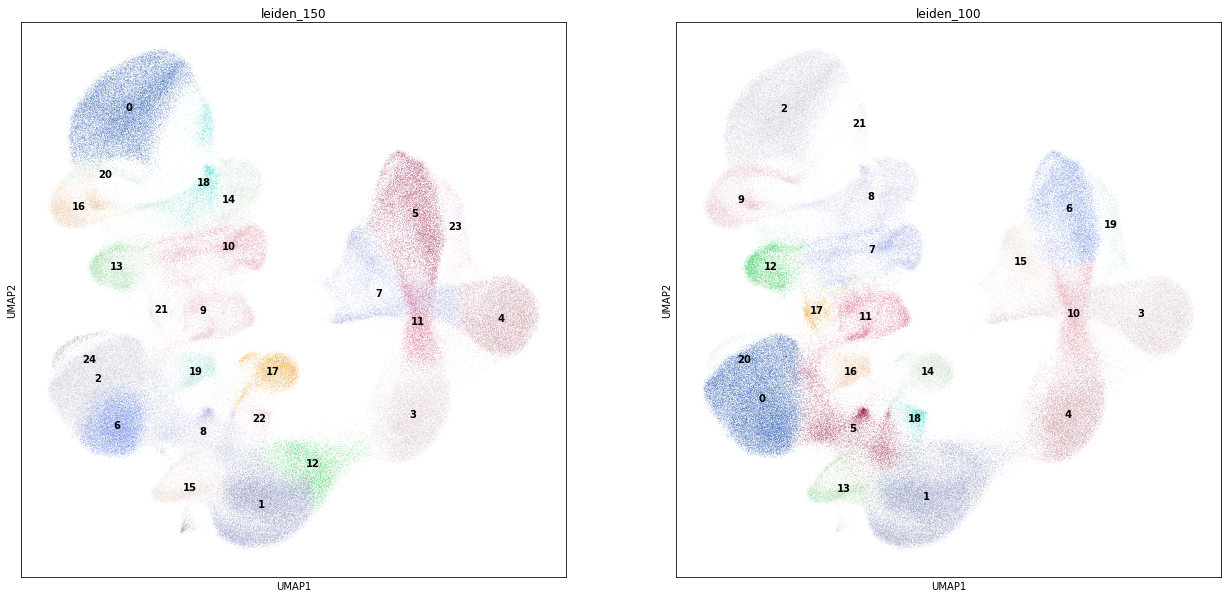

In [4]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150", "leiden_100"], legend_loc="on data")

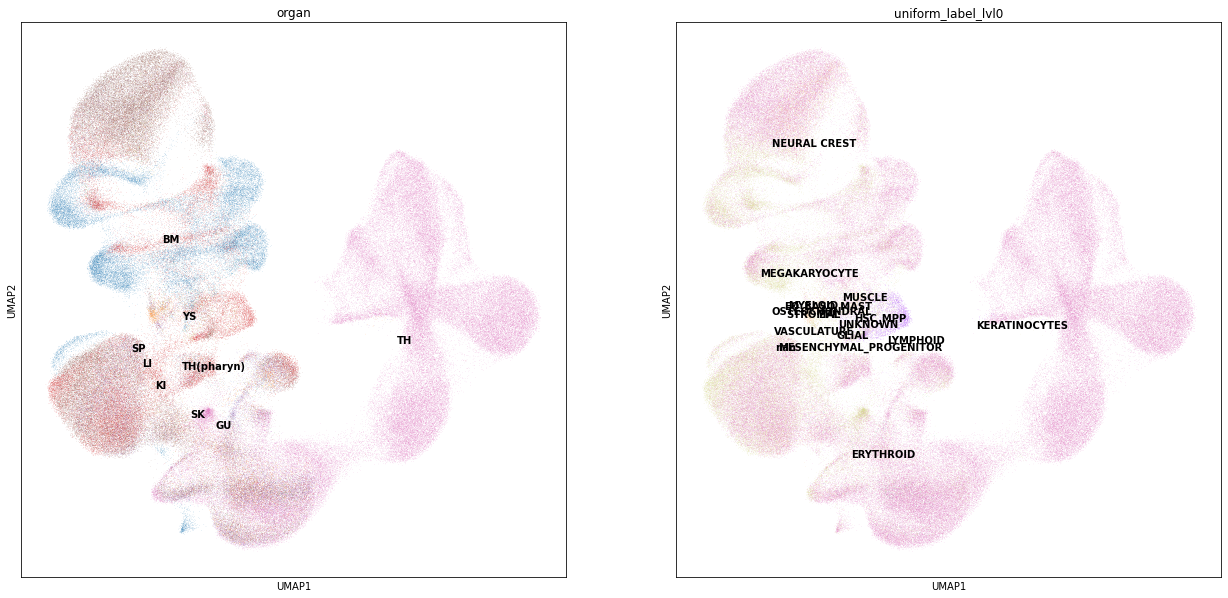

In [5]:
sc.pl.umap(adata, color=["organ", 'uniform_label_lvl0'], legend_loc="on data")

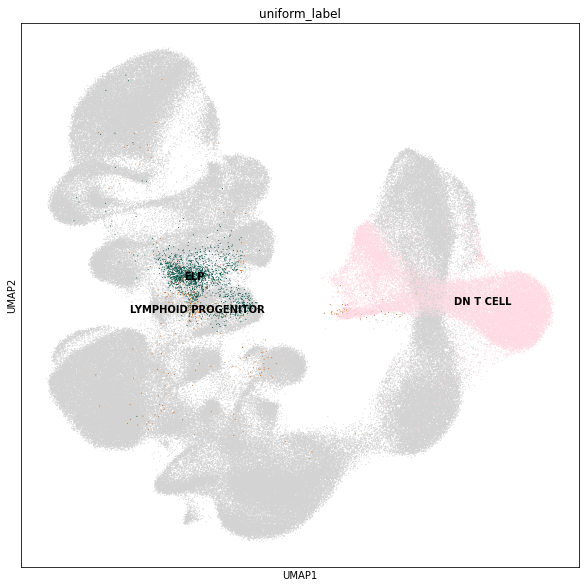

In [13]:
sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=["LYMPHOID PROGENITOR", "ELP", "DN T CELL"], size=4)

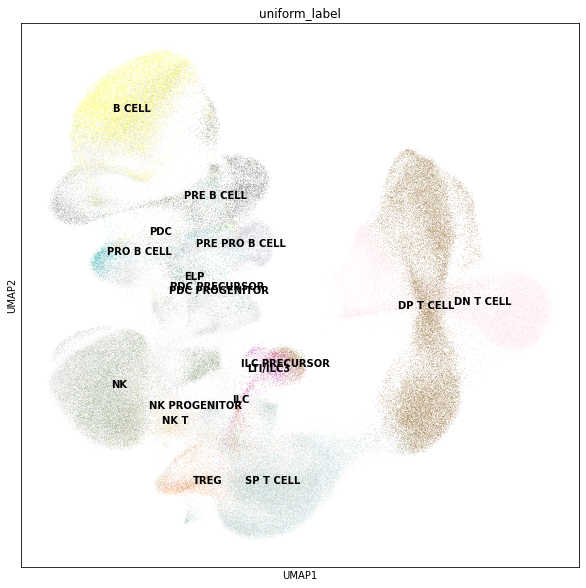

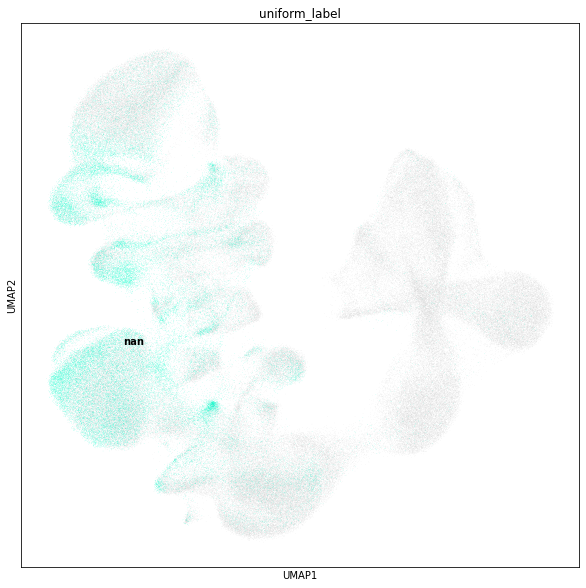

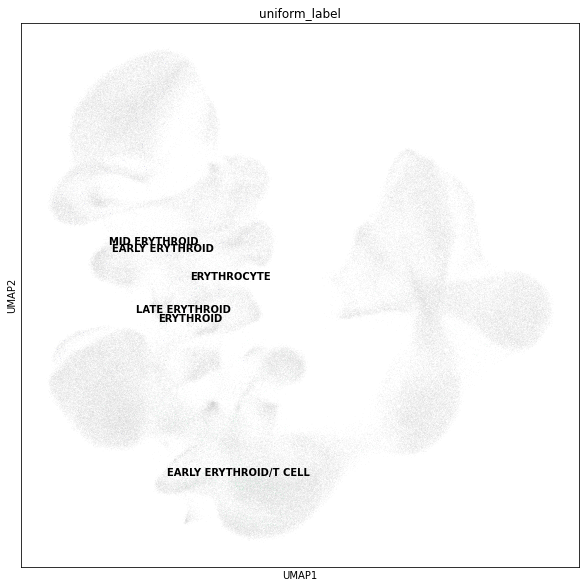

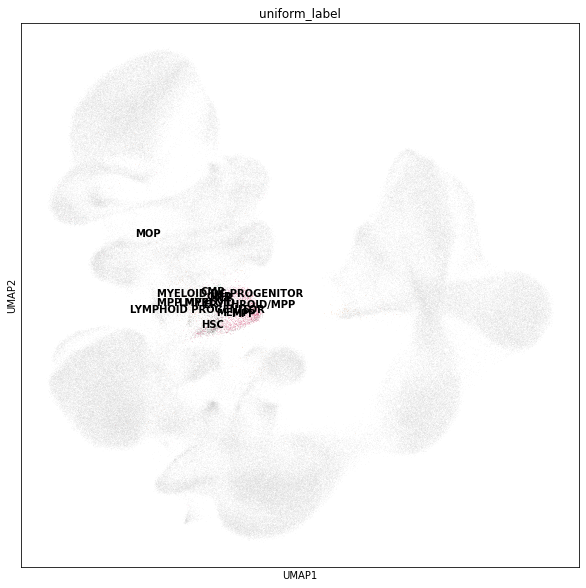

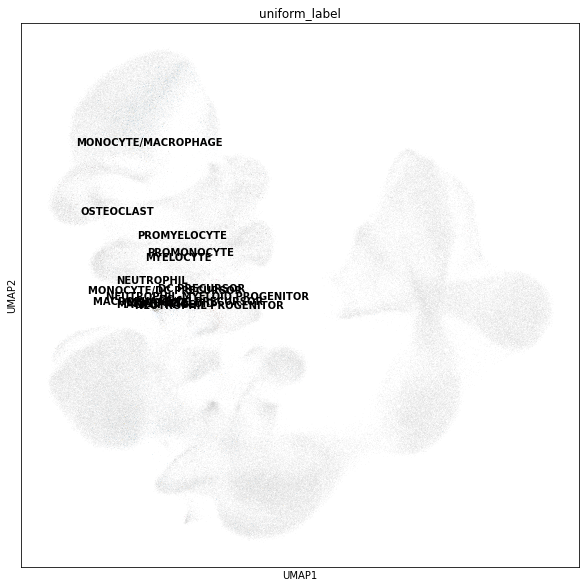

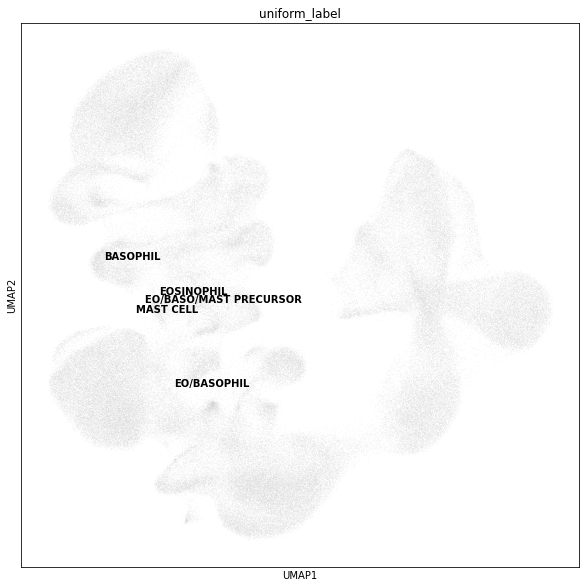

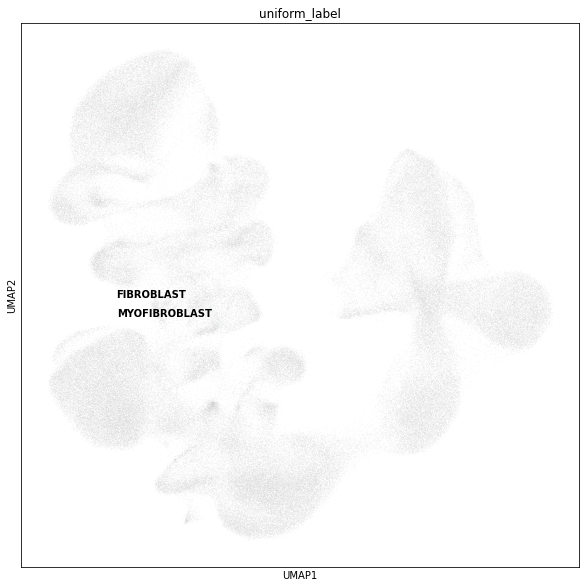

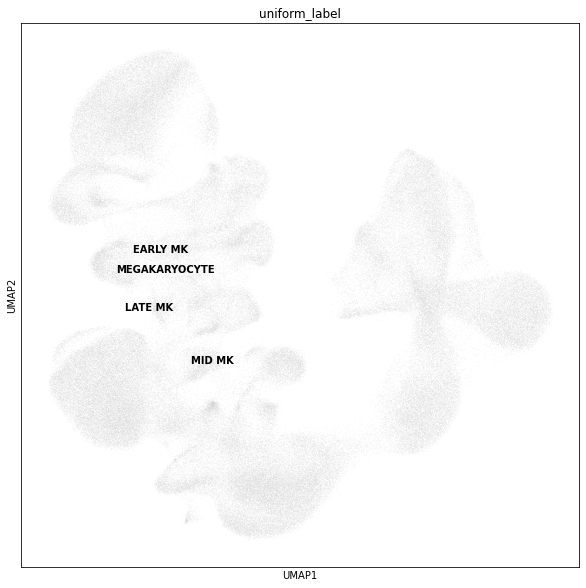

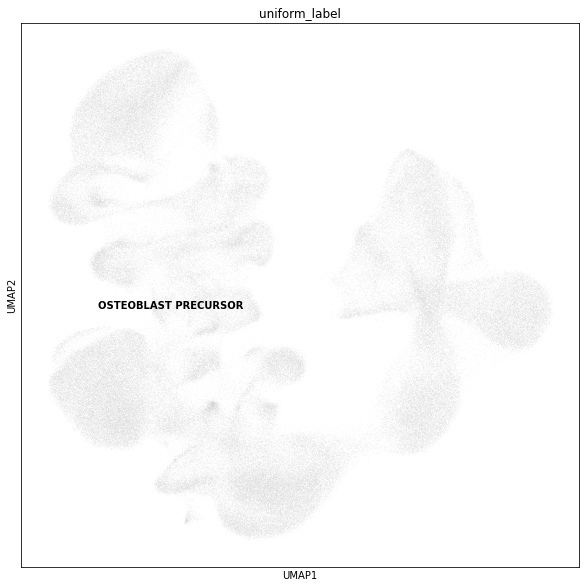

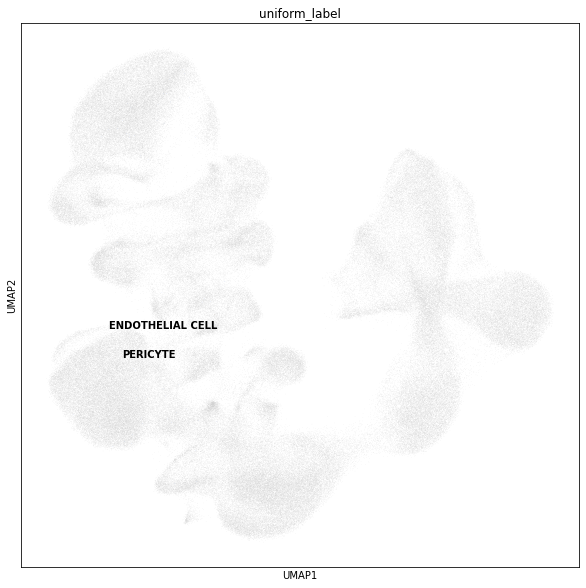

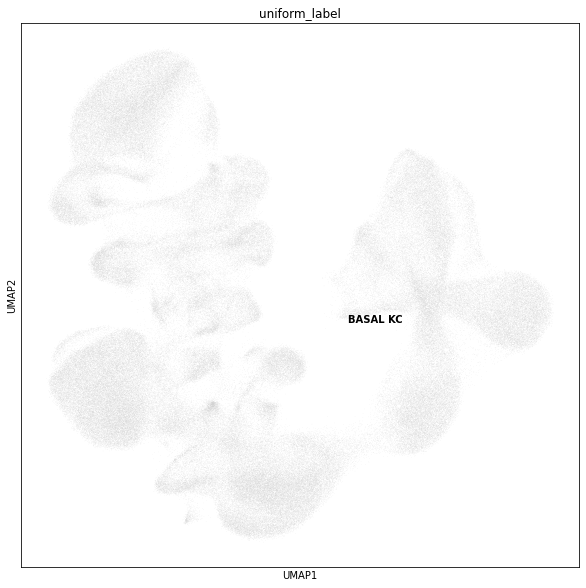

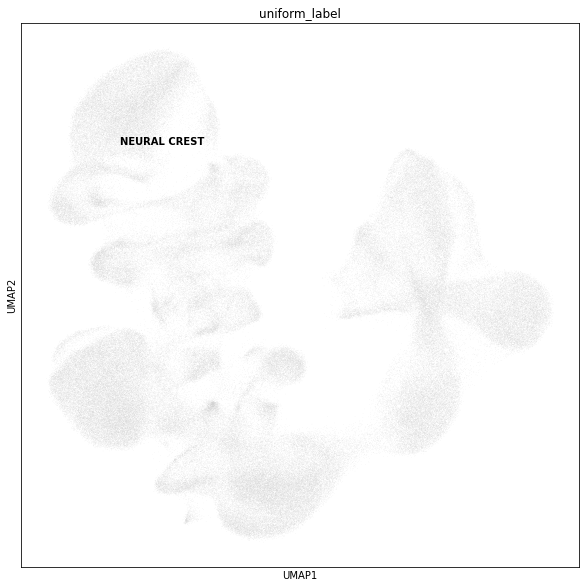

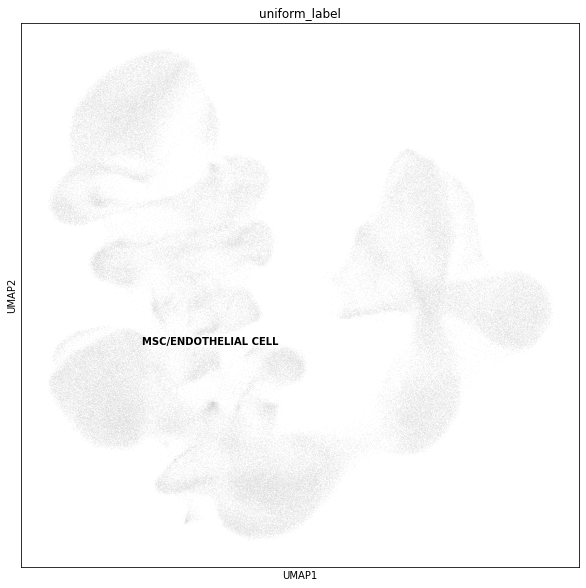

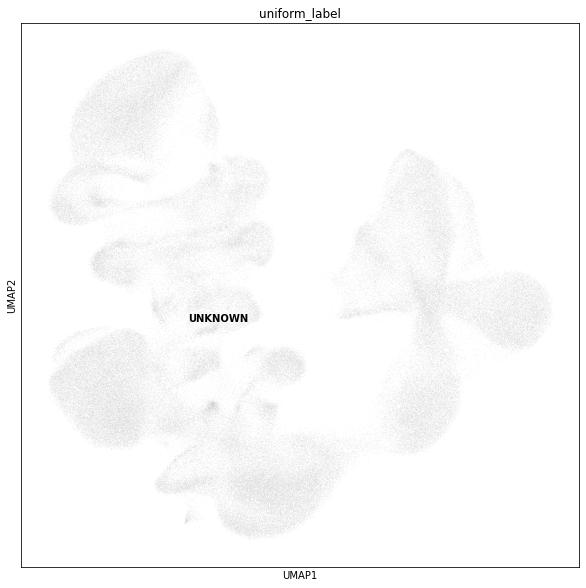

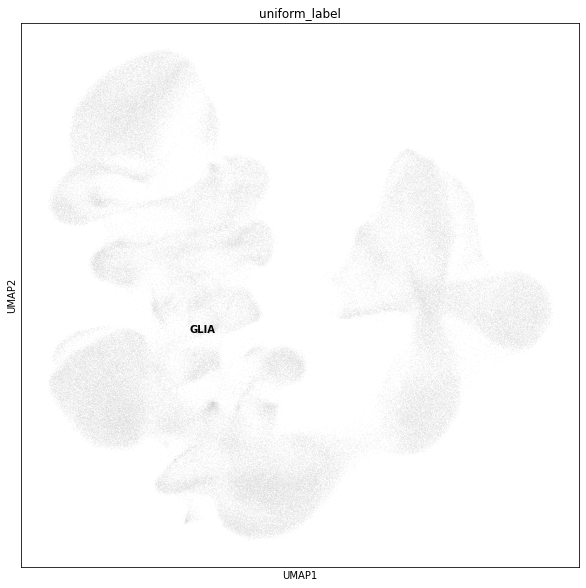

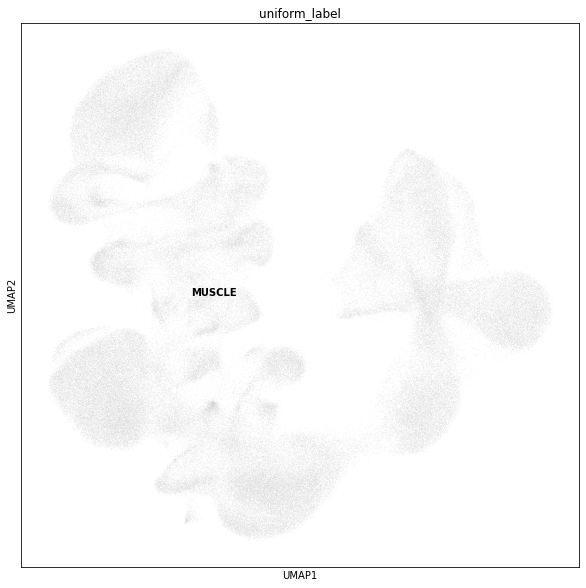

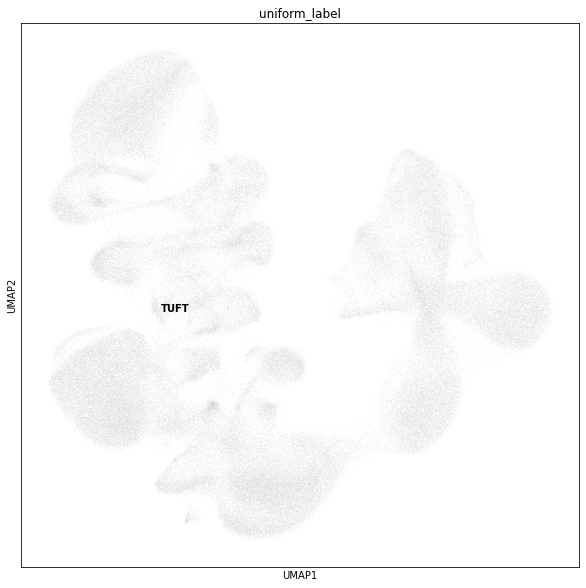

In [7]:
for o in adata.obs['uniform_label_lvl0'].unique():
    sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=adata.obs['uniform_label'][adata.obs['uniform_label_lvl0'] == o].unique())

### Annotate clusters using most frequent label 

In [8]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

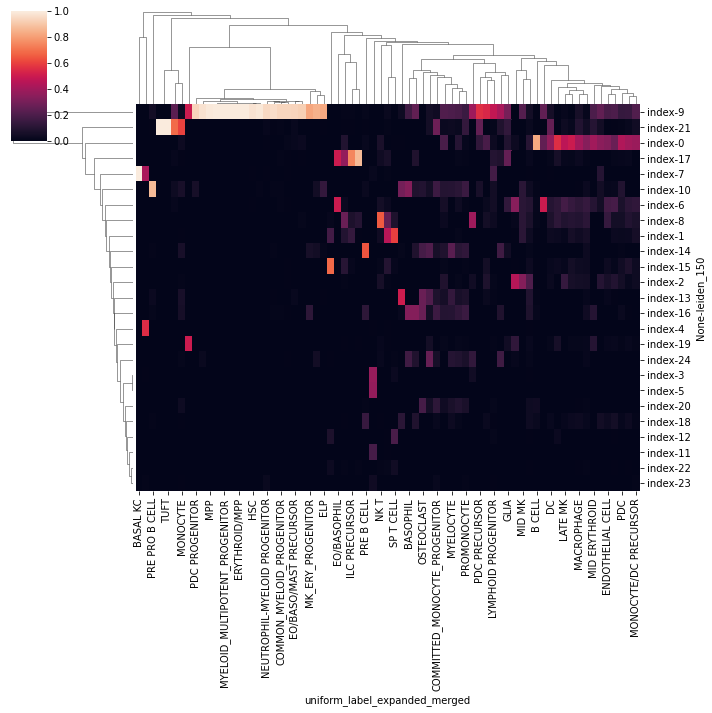

In [9]:
import seaborn as sns
sns.clustermap(cl_counts.T/cl_counts.sum(1))

... storing 'leiden_150_pred_label' as categorical


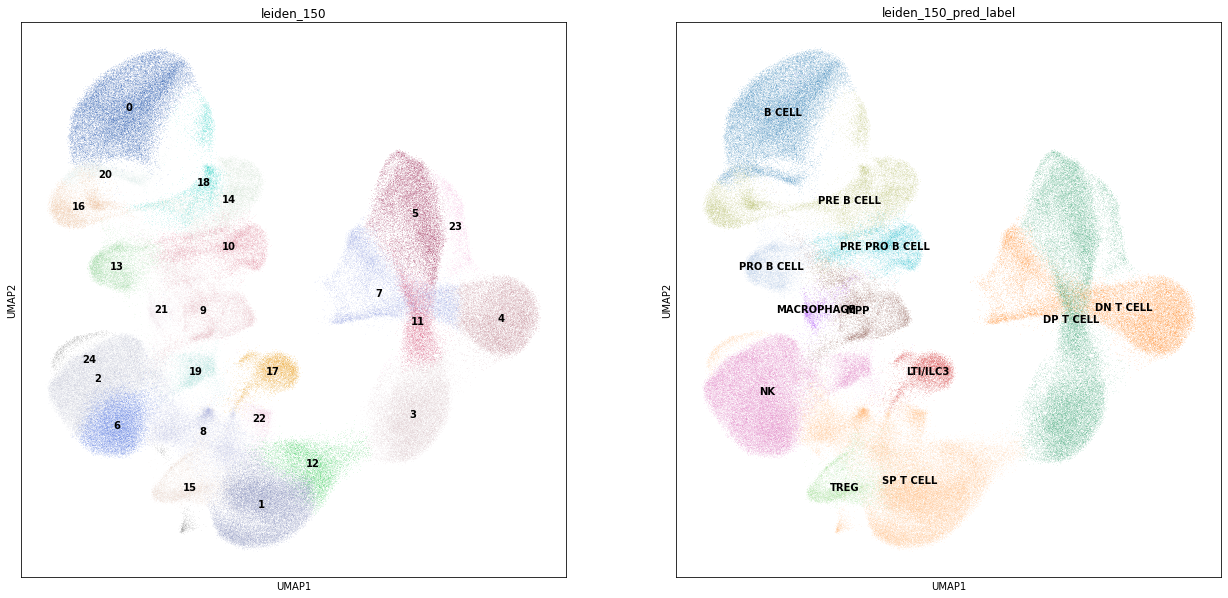

In [10]:
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")

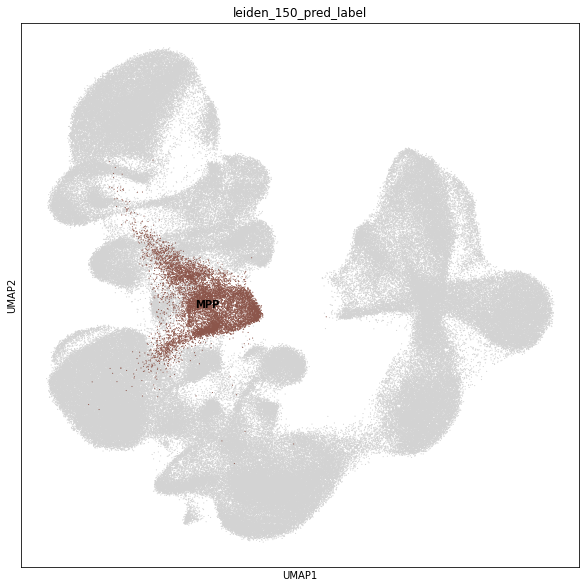

In [11]:
sc.pl.umap(adata, color=["leiden_150_pred_label"], legend_loc="on data", size=5, groups="MPP")

## Split in NKT/B
Here I save B with the progenitors

In [23]:
## Define hierarchy for making data subsets
pfi_splitting_df = adata.obs[['leiden_150_pred_label']].drop_duplicates()

pfi_splitting_df["split_3"] = [
    "NKT" if pfi_splitting_df['leiden_150_pred_label'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "TREG", "LTI/ILC3"]
    else "B" if "B CELL" in pfi_splitting_df['leiden_150_pred_label'].loc[i] or pfi_splitting_df['leiden_150_pred_label'].loc[i]=="MPP" 
    else "MYELOID"
    for i in pfi_splitting_df.index
]

pfi_splitting_df["split_3"] = ["MYELOID" if pfi_splitting_df["split_3"].loc[i] == "MYELOID/LYMPHOID" 
                               else pfi_splitting_df["split_3"].loc[i] 
                               for i in pfi_splitting_df.index
                              ]



pfi_splitting_df.sort_values(['split_3'])

leiden_150_pred_label  split_3
0           PRE PRO B CELL        B
2                   B CELL        B
3               PRE B CELL        B
22                     MPP        B
176             PRO B CELL        B
70              MACROPHAGE  MYELOID
1                       NK      NKT
21               SP T CELL      NKT
43                LTI/ILC3      NKT
63                    TREG      NKT
2245             DP T CELL      NKT
3843             DN T CELL      NKT

In [24]:
adata.obs = adata.obs[[x for x in adata.obs.columns if "split" not in x]]
adata.obs = adata.obs.merge(pfi_splitting_df, on=['leiden_150_pred_label'], how='left', indicator=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


... storing 'split_3' as categorical


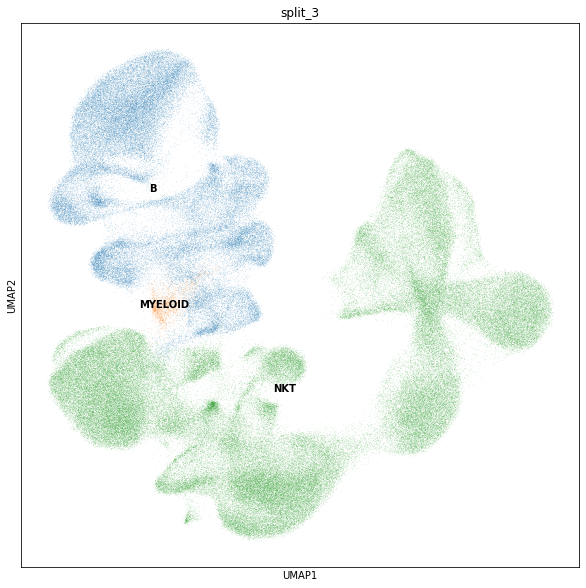

In [25]:
sc.pl.umap(adata, color=["split_3"], legend_loc="on data")

In [17]:
adata_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
adata_raw = adata_raw[adata.obs_names]

In [19]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118'
split_col = "split_3"

splits = adata.obs[split_col].unique()

In [26]:
splits[:2]

['B', 'NKT']
Categories (3, object): ['B', 'NKT', 'MYELOID']

In [27]:
for s in splits[:2]:
    adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
    sdata = adata_raw[adata.obs[split_col]==s]
    print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
    sdata.write_h5ad(adata_name)

Saving B anndata (74637 cells, 9 organs)
Saving NKT anndata (168414 cells, 9 organs)
